In [42]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

def overlay_rasters(high_res_path, low_res_path, output_path):
    """
    Fill holes in high-res raster with upscaled low-res data.
    """
    # Read high-res raster
    with rasterio.open(high_res_path) as high_src:
        high_data = high_src.read(1)
        profile = high_src.profile
    
    # Read low-res raster  
    with rasterio.open(low_res_path) as low_src:
        low_data = low_src.read(1)
        
        # Upscale low-res to match high-res grid
        upscaled = np.empty_like(high_data)
        reproject(
            low_data, upscaled,
            src_transform=low_src.transform,
            dst_transform=high_src.transform,
            src_crs=low_src.crs,
            dst_crs=high_src.crs,
            resampling=Resampling.cubic
        )
    
    # Fill holes (NoData) in high-res with upscaled low-res
    holes = (high_data == profile['nodata']) | np.isnan(high_data)
    result = high_data.copy()
    result[holes] = upscaled[holes]
    
    # Save result
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(result, 1)
    
    return result

def upscale_raster(low_res_path, high_res_path, output_path, method=Resampling.bilinear):
    """
    Upscale low-res raster to match high-res grid, then overlay with high-res data.
    """
    # Read high-res raster (this defines our target grid)
    with rasterio.open(high_res_path) as high_src:
        high_data = high_src.read(1)
        profile = high_src.profile
    
    # Read and upscale low-res raster to match high-res grid
    with rasterio.open(low_res_path) as low_src:
        low_data = low_src.read(1)
        
        # Create upscaled array with same shape as high-res
        upscaled = np.empty_like(high_data, dtype=low_data.dtype)
        
        reproject(
            low_data, upscaled,
            src_transform=low_src.transform,
            dst_transform=high_src.transform,
            src_crs=low_src.crs,
            dst_crs=high_src.crs,
            resampling=method
        )
    
    # Where high-res has valid data, use it. Otherwise use upscaled low-res
    has_high_res_data = ~((high_data == profile.get('nodata')) | np.isnan(high_data))
    result = np.where(has_high_res_data, high_data, upscaled)
    
    # Save upscaled result
    profile.update(dtype=result.dtype)
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(result, 1)
    
    return result

def upscale_dem_with_blending(low_res_dem, high_res_reference, output_path, 
                             method=Resampling.cubic, blend_distance=5):
    """
    Upscale low-res DEM with tight, smooth blending to avoid artifacts.
    
    Parameters:
    -----------
    blend_distance : int
        Number of pixels for blending transition zone (default: 5 for tighter transitions)
    """
    from scipy.ndimage import distance_transform_edt, gaussian_filter
    
    # Read high-res reference
    with rasterio.open(high_res_reference) as ref_src:
        ref_data = ref_src.read(1)
        profile = ref_src.profile
    
    # Read and upscale low-res DEM
    with rasterio.open(low_res_dem) as low_src:
        low_data = low_src.read(1)
        
        # Create upscaled DEM array
        upscaled_dem = np.empty_like(ref_data, dtype=np.float32)
        
        reproject(
            low_data, upscaled_dem,
            src_transform=low_src.transform,
            dst_transform=ref_src.transform,
            src_crs=low_src.crs,
            dst_crs=ref_src.crs,
            resampling=method,
            src_nodata=low_src.nodata,
            dst_nodata=-9999
        )
    
    # Create masks
    nodata_mask = (ref_data == ref_src.nodata) | np.isnan(ref_data)
    if ref_src.nodata is None:
        nodata_mask = np.isnan(ref_data)
    
    valid_high_res = ~nodata_mask
    
    # Create distance-based blending weights
    distance_to_high_res = distance_transform_edt(~valid_high_res)
    
    # Create tighter transition weights using exponential falloff
    blend_weights = np.exp(-2 * distance_to_high_res / blend_distance)
    blend_weights = np.clip(blend_weights, 0, 1)
    
    # Apply lighter smoothing for tighter transitions
    blend_weights = gaussian_filter(blend_weights, sigma=0.5)
    
    # Apply bias correction in transition zone
    overlap_mask = valid_high_res & (distance_to_high_res <= blend_distance * 2)
    if np.any(overlap_mask):
        bias = np.median(ref_data[overlap_mask] - upscaled_dem[overlap_mask])
        upscaled_dem_corrected = upscaled_dem + bias
    else:
        upscaled_dem_corrected = upscaled_dem
    
    # Blend the datasets
    final_dem = np.where(valid_high_res, 
                        blend_weights * ref_data + (1 - blend_weights) * upscaled_dem_corrected,
                        upscaled_dem_corrected)
    
    # Update profile for output
    profile.update(dtype=np.float32, nodata=-9999)
    
    # Save result
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(final_dem.astype(np.float32), 1)
    
    return final_dem
# Usage
# result = overlay_rasters('high_res.tif', 'low_res.tif', 'merged.tif')

In [ ]:
highres = '../datasets/rasters/GrandPierre_fix.tif'
lowres = '../datasets/rasters/EastCoast_GEBCO_2024.tif'
merged = 'merged.tif'
result = overlay_rasters(highres, lowres, merged)

In [35]:
result = upscale_raster(lowres, highres, 'upscaled_nearest.tif', method=Resampling.nearest)

In [43]:
t = upscale_dem_with_blending(lowres, highres, merged, 
                             method=Resampling.cubic, blend_distance=10)

Text(0.5, 1.0, 'Merged Raster')

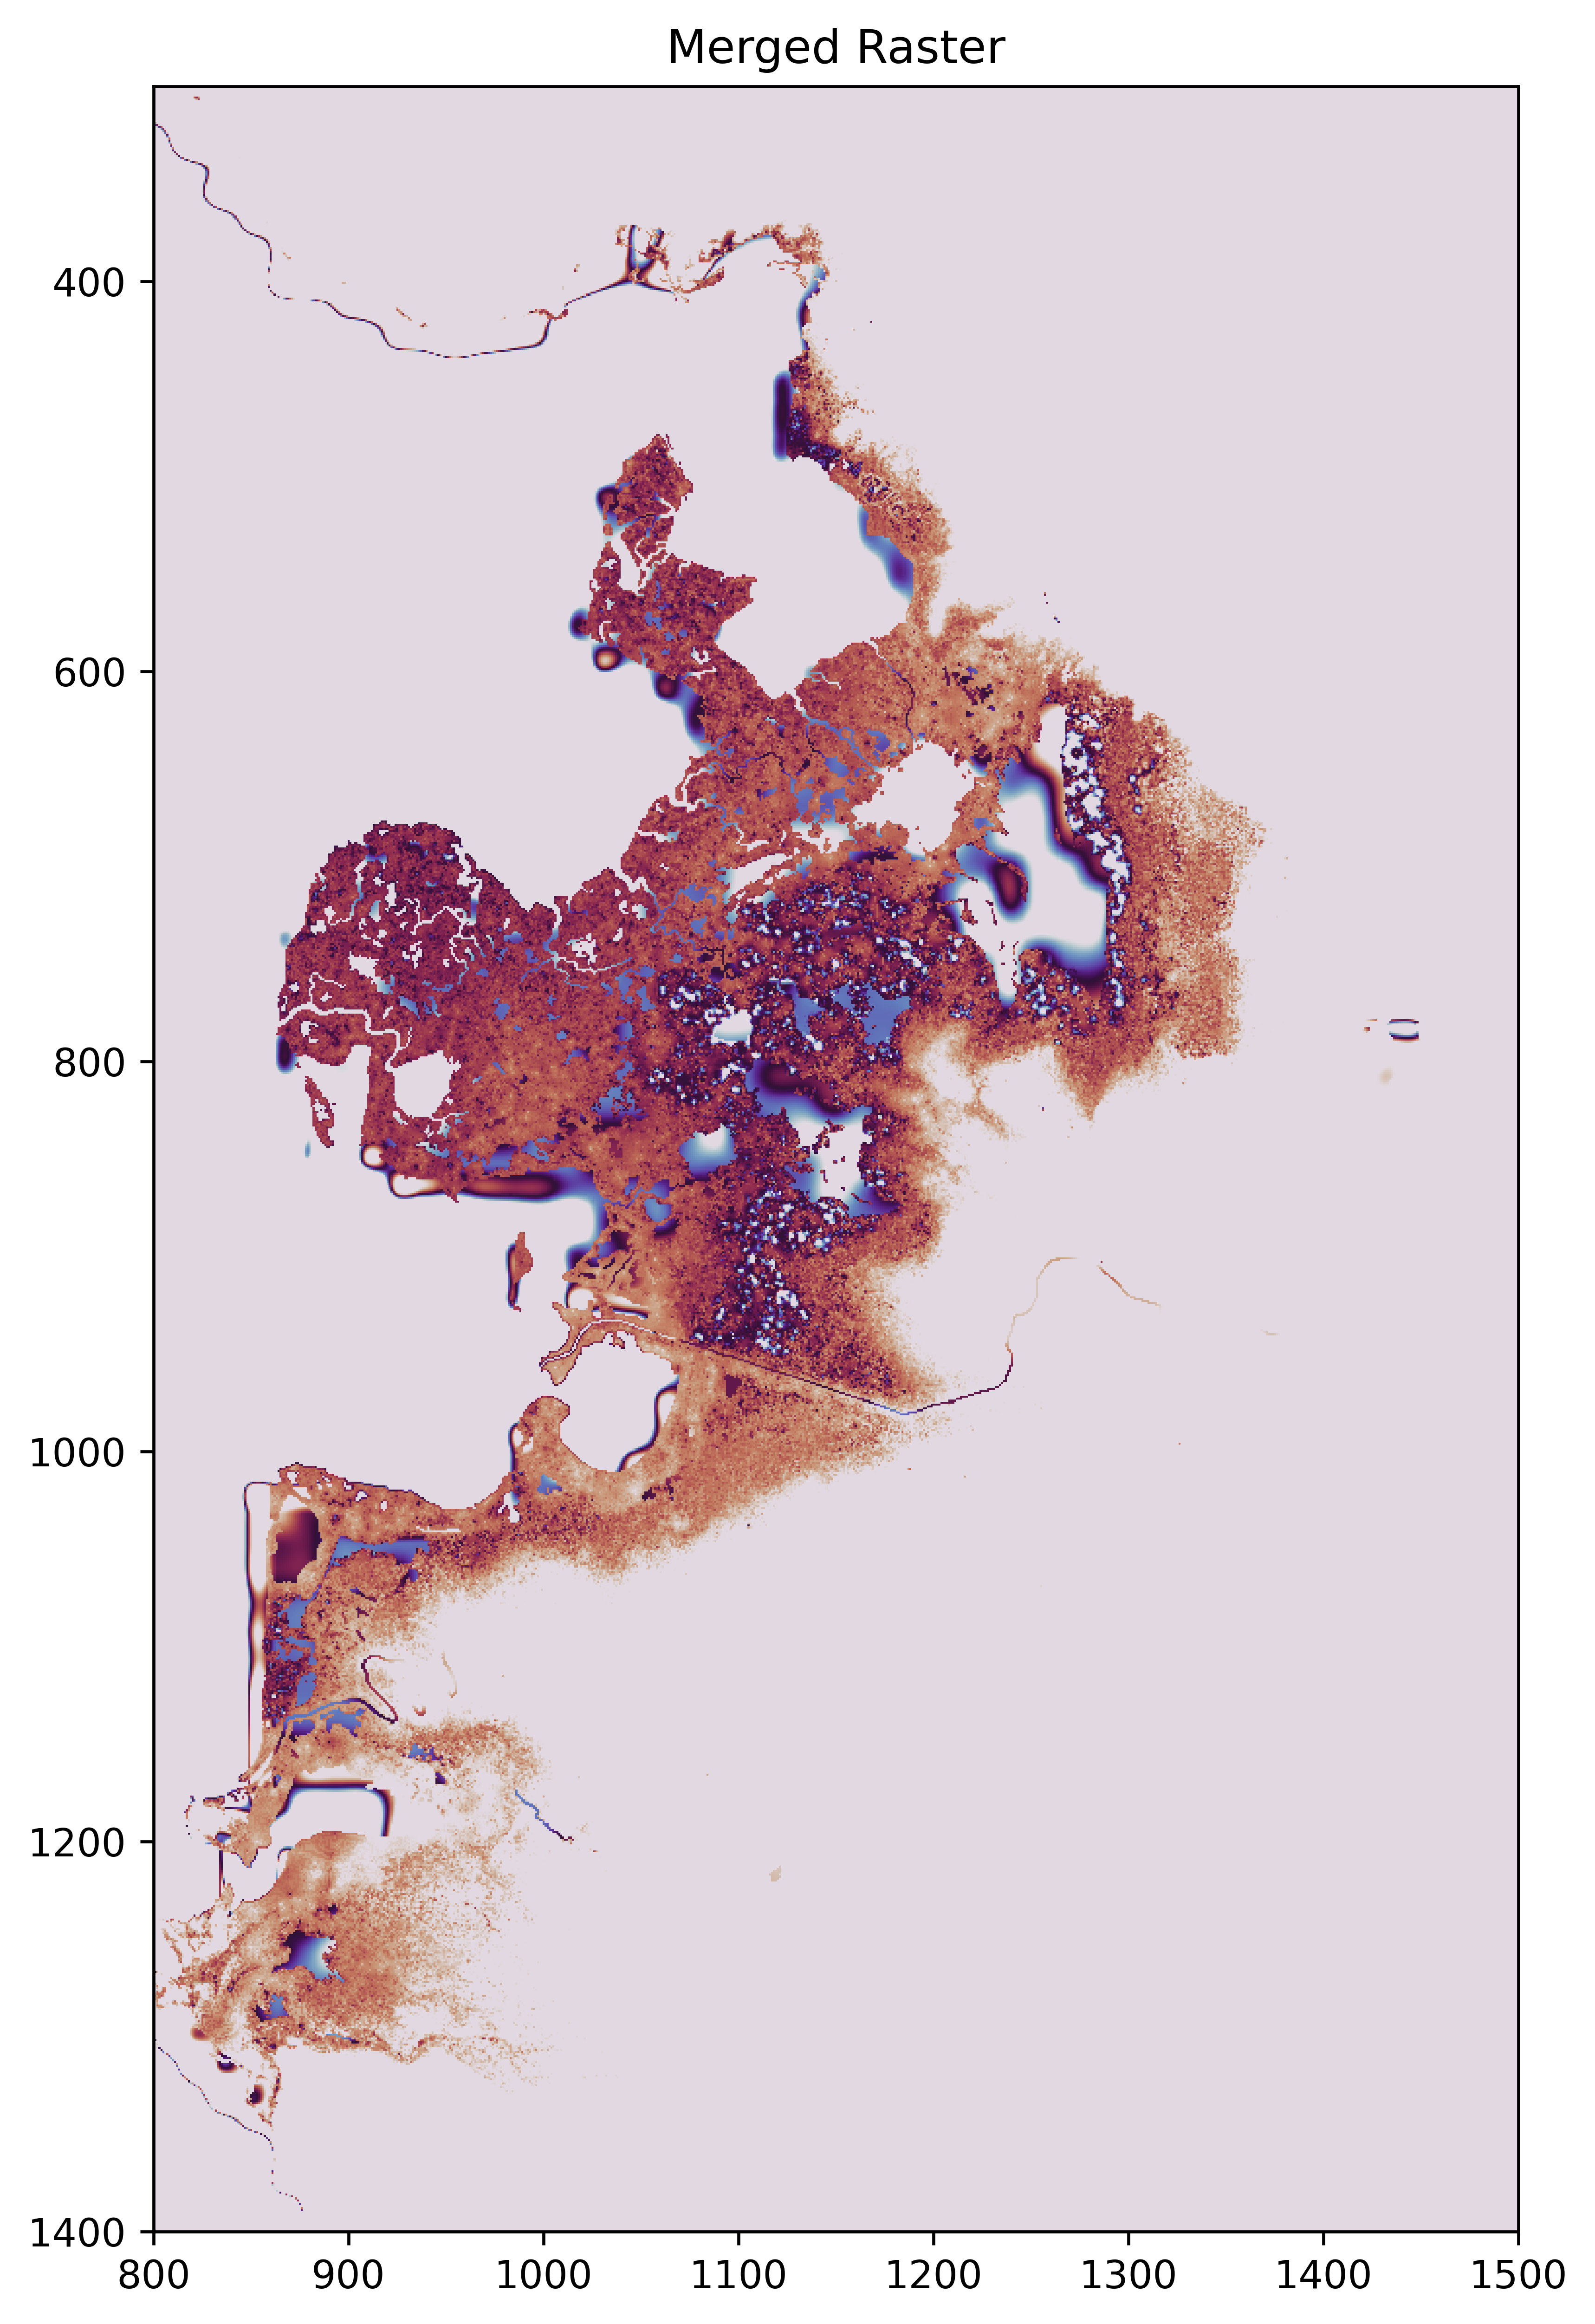

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10), dpi=600)
ax.imshow(t, cmap='twilight', vmin=-2, vmax=1)
ax.set_xlim(800, 1500)
ax.set_ylim(1400, 300)
ax.set_title('Merged Raster')